In [2]:
latex.add_to_preamble(r"\usepackage{amsmath}")

In [3]:
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}')

In [4]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout
            
            
import warnings
            
@contextmanager
def suppress_warnings():
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        yield

# Verifying temporal properties of continuous systems under contexts and masks
Thomas Wright, Ian Stark

## Outline

 - We introduce continuous models, temporal logic (with contexts), and the flow* validated-integrator
 - We explain our verification method combining flow* and three-valued signals
 - We introduce temporal masks and show how they increase verification efficiency

## Continuous dynamical models

Predator-prey role-reversal (Barkai & McQuaid 1988): 

<img class="xxlarge-image" src="./ppar-lunch-images/marcus-island.webp">

## A continuous dynamical model

An ODE model e.g. Sánchez-Garduño et al. (2014):

\begin{align}
    \frac{\mathrm d x}{\mathrm d t}
    & = bx(1 - x) - cx(k - x)y \\
    \frac{\mathrm d y}{\mathrm d t}
    & = - ey(1 + y) + fx(k - x)y
\end{align}

Can be specified directly via ODEs or using a higher-level modelling language such as the bond-calculus.

$x$ prey, $y$ predator, $b$ growth rate of $x$, $c$ damage intensity of $x$ on $y$,
$e$ predator death rate, $f$ benefit from predation.

Interesting feature: predator and prey switch role depending on concentrations.



In [5]:
from ulbc import *

In [6]:
R.<x,y> = QQ[]
us = [x,y]
k=RIF(0.8); b=RIF(0.6); c=RIF(0.3); e=RIF(0.05); f=RIF(2)
vf = vector([b*x*(RIF(1)-x) - c*x*(k-x)*y,
            -e*y*(RIF(1)+y)+f*x*(k-x)*y])
v0 = [RIF(0.5), RIF(2.0)]
v1 = [RIF(0.4), RIF(2.5)]
v2 = [RIF(1,1.2), RIF(4,6)]

In [7]:
p = streamline_plot(tuple(vf),(x,0,1.5),(y,0,8), density=1.2)#, axes_labels=["$x$", "$y$"])
s = lambda: p.show(figsize=[16,8], axes_pad=False)

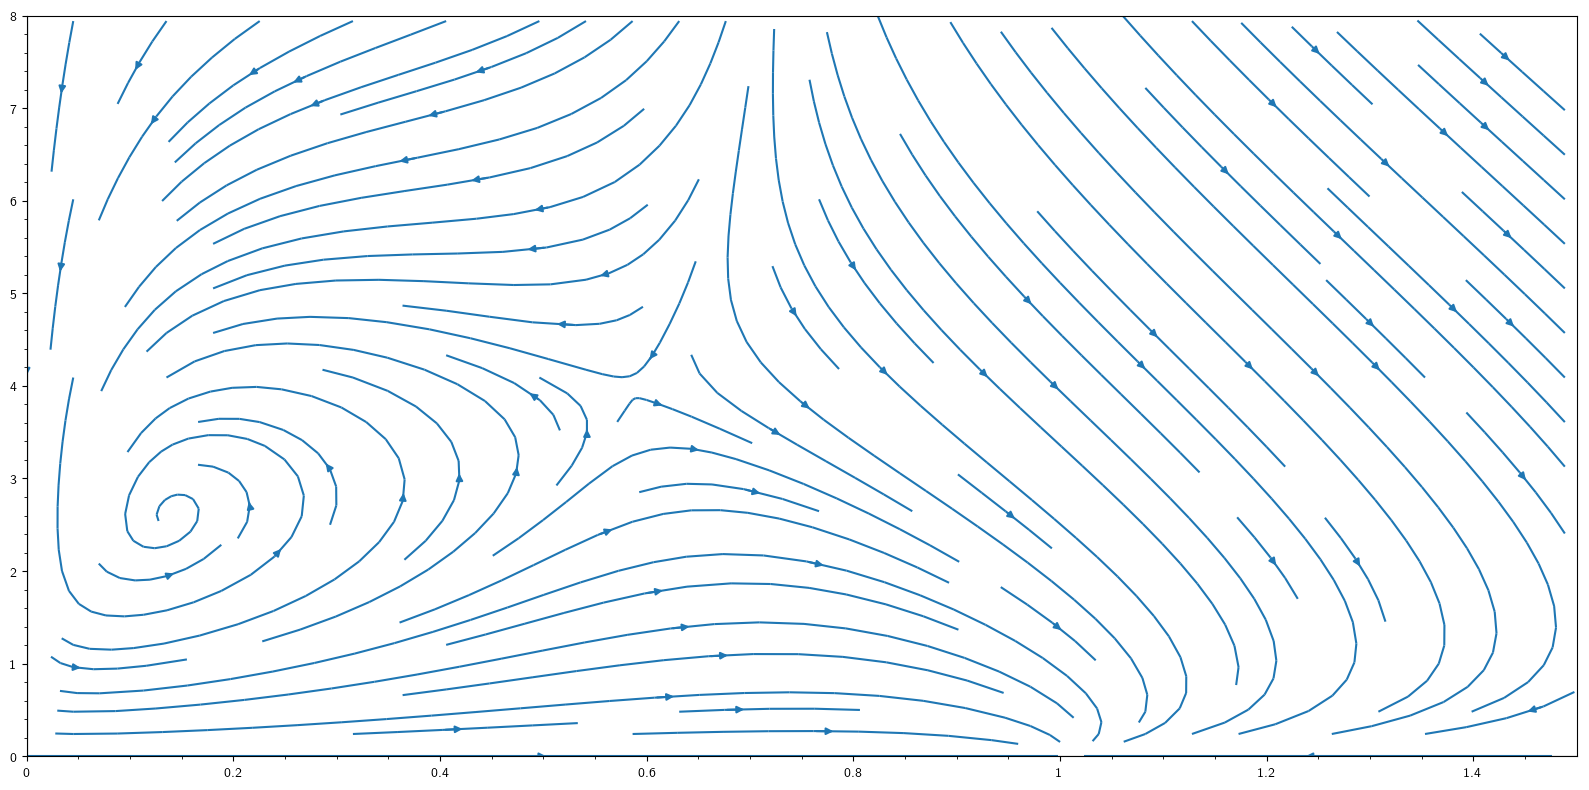

In [8]:
s()

In [9]:
Reach(vf, v2, 1, step=0.02, order=5,
      precondition=1,
      estimation=1e-3,
      integrationScheme=2,
      cutoff_threshold=1e-7,
      symbolic_composition=True,
      precompose_taylor_models=True, verbosity=10).num_flowpipes

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing

50

## Temporal properties

Many interesting properties of this system can be specified in temporal logic
$$
\begin{array}{rccccc}
    \varphi, \psi &\mathrel{::=}&
        g(\mathrm x) > 0 \\
        &|&
        \varphi \wedge \psi
        &|&
        \varphi \vee \psi
        &|&
        \neg \varphi \\
        &|&
        \mathop{\mathbf{G}_{[a, b]}} \varphi
        &|&
        \mathop{\mathbf{F}_{[a, b]}} \varphi
        &|&
        \varphi \mathop{\mathbf{U}_{[a, b]}} \psi \\
        &|&
        \mathcal C \triangleright \varphi
\end{array}
$$
where $g(\mathbf x)$ is a function (e.g. polynomial) of the state variables.

e.g.
 - $$\mathop{\mathbf{G}_{[0, 5]}} ((x - 1)^2 + y^2 > 0.2)$$
 - $$\mathop{\mathbf{F}_{[0, 5]}} ((x - 1)^2 + y^2 > 0.2)$$
 - $$((x - 1)^2 + y^2 > 0.2) \mathop{\mathbf{U}_{[0, 5]}} (x > 1.3)$$

Context operators $\mathcal C \triangleright \varphi$ where $\mathcal C = [a_1, b_1] \, x_1 \parallel  \ldots \parallel [a_n, b_n] \, x_n$

<!--- [a_2, b_2] \, x_2 \parallel -->

e.g.
$$\mathop{\mathbf{G}_{[0.4, 1.2]}} ([0.3,0.4] \, x \triangleright \mathop{\mathbf{F}_{[4, 5]}} ((x - 1)^2 + y^2 > 0.2))$$

### Verification using flow*

Flow* performs validated integration of continuous system: given a system $\frac{\mathrm{d} \mathbf x}{\mathrm d t} = f(\mathrm x)$ and set of initial conditions $\mathbf x_{0} \in B$, returns a sequence of *Taylor models*
$$
    (\mathbf p_1, I_1), \ldots, (\mathbf p_n, I_n)
$$
consisting of (vectors of) polynomials $p_k:B \times [a_k, b_k] \rightarrow {\mathbb R}^n$ and (vectors of) intervals $I_k$ which jointly enclose the solution.

In [10]:
#input_box("1,1.2", label="$x$")
import time

reach = None

def pfun(xvar=range_slider(0, 1.4, default=(1, 1.2), label="$x$"),
         yvar=range_slider(0, 8, default=(4, 6), label="$y$"),
         #step=slider(0, 0.2, default=0.02, label="step", step_size=0.001),
         #order=slider(0, 20, default=5, label="order", step_size=1),
         auto_update=False):
    global reach
    
    step = 0.02
    order = 5
    
    p = streamline_plot(tuple(vf), (x,0,1.5), (y,0,8), density=1.2, color='gray')#, axes_labels=["$x$", "$y$"])
    v = vector([RIF(xvar), RIF(yvar)])
    initials = [xvar, yvar]
    p += text(r"$\zeta = \mathop{\mathbf{G}_{[0, 5]}} ((x - 1)^2 + y^2 > 0.2)$",
              (1.1, 7),
              fontsize="xx-large", color="black",
              bounding_box = {'boxstyle': 'round,pad=0.5', 'fc': 'white', 'ec': 'white'})
    p += polygon([(v[0].lower(), v[1].lower()),
                  (v[0].lower(), v[1].upper()),
                  (v[0].upper(), v[1].upper()),
                  (v[0].upper(), v[1].lower())],
                  color='orange')
    p += region_plot((lambda x, y: (x - 1)^2 + y^2 - 0.2 < 0),
                     (x, 0, 1.5), (y, 0, 8),
                     incol='pink', plot_points=500, bordercol='red',
                     zorder=30) 
    with suppress_stdout():
        t0 = time.time()
        reach = Reach(vf, initials, 5+1e-3, step=step, order=order, precompose_taylor_models=True)
        t1 = time.time()
        if reach.ran:
            p += reach.sage_interval_plot('x', 'y', aspect_ratio='automatic')
    p.set_aspect_ratio(1/8)
    p.show(figsize=[12,6], axes_pad=False)
    if reach.ran:
        with suppress_stdout():
            b = G(RIF(0, 5), Atomic((x - 1)^2 + y^2 - 0.2)).signal(reach, vf)(0)
    else:
        b = None
    print("time: {:.3f} sec\t\tζ is {}\t\t{} flowpipes generated{}".format(
        t1 - t0, "Unknown" if b is None else str(b), reach.num_flowpipes,
        "" if reach.result == 2 else " (flowpipe diverged)"))

In [11]:
interact(layout=[['xvar', 'yvar', 'auto_update']])(pfun);

Manual interactive function <function pfun at 0x7f4b2a647620> with 2 widgets
  xvar: TransformFloatRangeSlider…

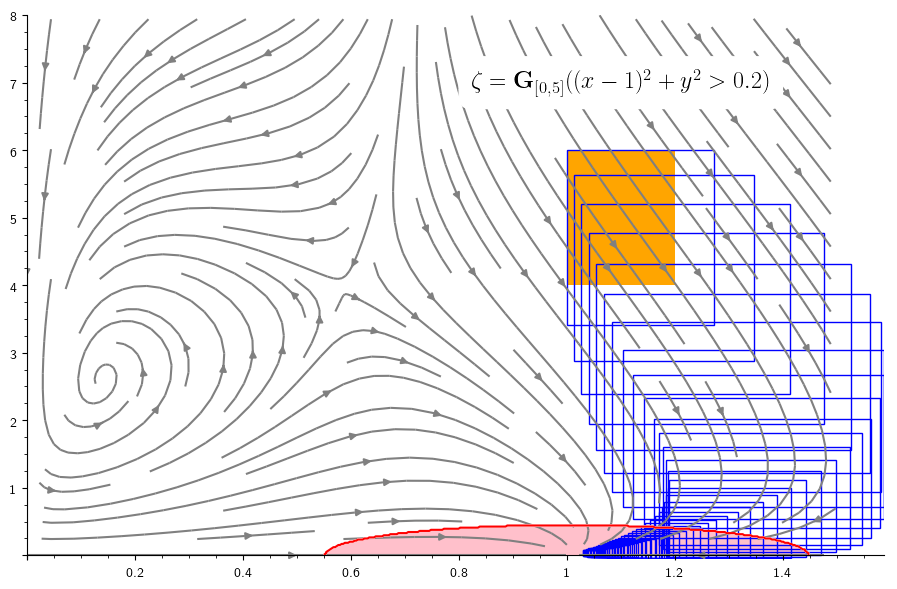

time: 8.106 sec		ζ is False		251 flowpipes generated


In [12]:
pfun((1, 1.2), (4, 6))

In G.signal
domain = [0.0000000000000000 .. 5.0000000000000009]
roots = [[0.77527807303528639 .. 2.7800000000000025]]
seg_domain = [0.0000000000000000 .. 5.0000000000000009]
roots = [[0.77527807303528639 .. 2.7800000000000025]]


/usr/lib64/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


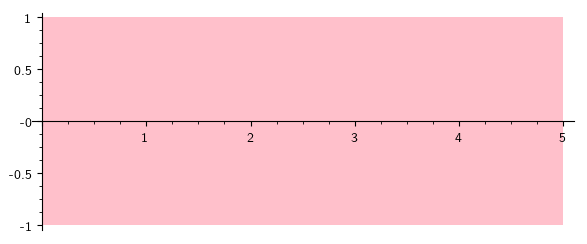

In [13]:
G(RIF(0, 5), Atomic((x - 1)^2 + y^2 - 0.2)).signal(reach, vf).plot()

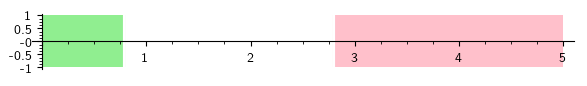

In [14]:
with suppress_stdout():
    with suppress_warnings():
        Atomic((x - 1)^2 + y^2 - 0.2).signal(reach, vf).plot(aspect_ratio=1/4).show()

### Verification method: three-valued signals

We will verify temporal propositions using three-valued signals:

A three-valued signal is a function $s:\mathbb R_{\geq 0} \to \{\mathbf F, \mathbf U, \mathbf T\}$.

Can be represented as a sequence $(I_k, v_k)_k$ of time intervals $I_k = [a_k, b_k] \subseteq \mathbb R_{\geq 0}$ and boolean values $v_k \in \{\mathbf F, \mathbf T\}$.

We associate with each proposition a signal, soundly enclosing its truth value over time.

(extends methods proposed by Banks and Stark (2015), Ishii, Yonezaki, and Goldsztejn (2016), and Maler and Nickovic (2004))

E.g. atomic proposition $\varphi = \displaystyle(x - 1)^2 + y^2 > 0.2$ has signal $s_{\varphi}:\mathbb R_{\geq 0} \to \{\mathbf F, \mathbf U, \mathbf T\}$ defined by
$$s_{\varphi} = (([0, 0.738], \mathbf T), ([2.348, 5], \mathbf F))$$

In [15]:
p_ratio = 1/2

In [16]:
sys_args = vf, v2, 10
sys_kwargs = dict(
    order=5, step=0.02,
    precondition=1,
    estimation=1e-3,
    integrationScheme=2,
    cutoff_threshold=1e-5,
    symbolic_composition=True,
)

In [17]:
P = Atomic((x - 1)^2 + y^2 - 0.2)
sigP = P.signal_for_system(*sys_args, **sys_kwargs)

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
Computed 501 flowpipes in 4.143942356109619 sec
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders

In [18]:
sigP

Signal([0.0000000000000000 .. 10.000000000000000], [([0.0000000000000000 .. 0.73999999999999611], True), ([2.3400000000000020 .. 10.000000000000000], False)], mask=None)

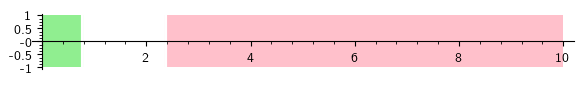

In [19]:
sigP.plot(aspect_ratio=p_ratio)

In [20]:
Q = Atomic(x - 1.1)
sigQ = Q.signal_for_system(*sys_args, **sys_kwargs)

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
Computed 501 flowpipes in 3.8888049125671387 sec
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
order

In [21]:
sigQ

Signal([0.0000000000000000 .. 10.000000000000000], [([0.64000000000000056 .. 3.2064719457580462], True), ([3.8200000000000033 .. 10.000000000000000], False)], mask=None)

E.g. atomic proposition $\displaystyle \psi \triangleq x > 1.1$ has signal $s_{\psi}:\mathbb R_{\geq 0} \to \{\mathbf F, \mathbf U, \mathbf T\}$ defined by
$$s_{\psi} = (([0.641, 3.206], \mathbf T), ([3.821, 5], \mathbf F))$$

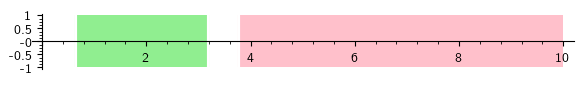

In [22]:
sigQ.plot(aspect_ratio=p_ratio)

In general we can find signals for atomic propositions by combining Flow* with the Extending Interval Newton method

<img src="./ppar-lunch-images/extended-newton-method1.png" class="large-image">

<img src="./ppar-lunch-images/extended-newton-method2.png" class="large-image">

<img src="./ppar-lunch-images/extended-newton-method3.png" class="large-image">

Here, for an atomic proposition $p : \mathbb R^n \to \mathbb R$, Taylor-model solution $\mathbf q : \mathbb R \to \mathbb R^n$, given system $\frac{\mathrm d \mathbf x}{\mathrm d t} = \mathbf h(t)$, we have a choice for $f$,

\begin{alignat}{2}
   f(t) & = p(\mathbf q(t))
   &\qquad\quad
   \text{functional composition} \\
   f(t) & = p(\mathbf y)[\mathbf y\mapsto\mathbf q(s)][s \mapsto t]
   &\qquad\quad
   \text{symbolic composition}
\end{alignat}
      
and can find 
\begin{align}
    f'(t)
    = \frac{\mathrm d f}{\mathrm d t}
    = \nabla p \cdot \mathbf h(\mathbf q(t)).
\end{align}

Hard accuracy/performance tradeoff between symbolic/interval methods &mdash; techniques required to adaptively manage this tradeoff.

Once we know the roots, it is easy to define a signal:

<img src="./ppar-lunch-images/monitoring-atomic.svg" class="xlarge-image">

This needs to be performed on every Taylor-model segment then the signals can be concatenated to give a signal for the overall system.

We can then compose these to give signals for complex propositions e.g.

In [23]:
p_ratio

1/2

In [24]:
res = graphics_array(
    [
        sigP.plot(aspect_ratio=p_ratio) + text(r'$\varphi$', (10.8, 1), fontsize="xx-large"),
        sigQ.plot(aspect_ratio=p_ratio) + text(r"$\psi$", (10.8, 1), fontsize="xx-large"),
        (sigP & sigQ).to_domain(RIF(0, 10)).plot(aspect_ratio=p_ratio)
            + text(r"$\varphi \wedge \psi$", (10.8, 1), fontsize="xx-large"),
        (sigP | sigQ).to_domain(RIF(0, 10)).plot(aspect_ratio=p_ratio)
            + text(r"$\varphi \vee \psi$", (10.8, 1), fontsize="xx-large"),
    ],
    4, 1
)

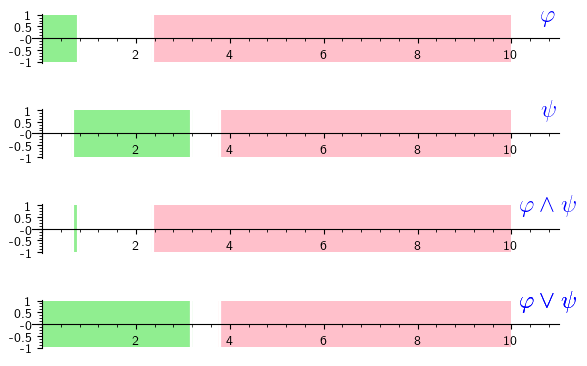

In [25]:
res

Or time shift signals for temporal operators:

In [26]:
res = graphics_array(
    [
         sigP.plot(aspect_ratio=p_ratio)
            + text('$\\varphi$', (10.8, 1), fontsize="xx-large"),
         sigP.G(RIF(2, 5)).plot(aspect_ratio=p_ratio)
            + text('$\\mathop{\\mathbf G_{[2, 5]}}\\varphi$', (10.8, 1), fontsize="xx-large"),
         sigP.F(RIF(2, 5)).plot(aspect_ratio=p_ratio)
            + text('$\\mathop{\\mathbf F_{[2, 5]}}\\varphi$', (10.8, 1), fontsize="xx-large")
    ],
    3, 1
)

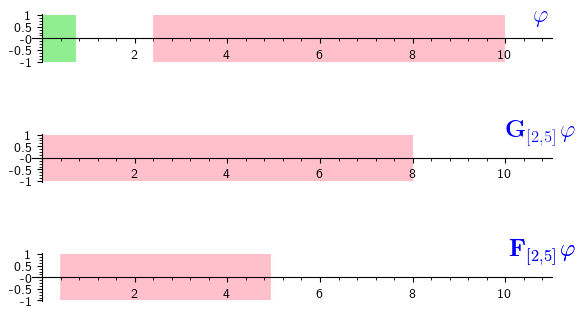

In [27]:
with suppress_warnings():
    res.show()

### Context operator

For context operator $\mathcal C \triangleright \varphi$

<img src="./ppar-lunch-images/context-diagram.svg" class="large-image">

<img src="./ppar-lunch-images/context-step1.svg" class="large-image">

<img src="./ppar-lunch-images/context-step2.svg" class="large-image">

<img src="./ppar-lunch-images/context-step4.svg" class="large-image">

e.g. $$x \triangleright \mathop{\mathbf{F}_{[4, 5]}} ((x - 1)^2 + y^2 > 0.2))$$

In [28]:
%%time
simple_prop_ctx = G(RIF(1, 2), {x: RIF(0.3,0.4)} >> F(RIF(4, 5), P))
simple_sig_ctx = simple_prop_ctx.signal_for_system(*sys_args, **sys_kwargs)

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
Computed 601 flowpipes in 4.1005637645721436 sec
In G.signal
In C.signal
{'order': 5, 'step': 0.0200000000000000, 'precondition': 1, 'estimation': 0.00100000000000000, 'integrationScheme': 2, 'cutoff_threshold': 0.0000100000000000000, 'symbolic_composition': True}
mask = None
in eval
fp.size = 601
fp_compo.size = 601
flowpipesCompo.size = 0
domains.size = 601
in loop
[0.0..12.001000000000001] overlaps [0.0..0.02]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [0.02..0.04]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [0.04..0.060000000000000005]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [0.060000000000000005..0.08000000000000002]
doing normal eva

in loop
[0.0..12.001000000000001] overlaps [1.100000000000001..1.120000000000001]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [1.120000000000001..1.140000000000001]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [1.140000000000001..1.160000000000001]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [1.160000000000001..1.180000000000001]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [1.180000000000001..1.200000000000001]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [1.200000000000001..1.220000000000001]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [1.

in loop
[0.0..12.001000000000001] overlaps [2.5600000000000023..2.5800000000000023]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [2.5800000000000023..2.6000000000000023]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [2.6000000000000023..2.6200000000000023]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [2.6200000000000023..2.6400000000000023]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [2.6400000000000023..2.6600000000000024]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [2.6600000000000024..2.6800000000000024]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] 

in loop
[0.0..12.001000000000001] overlaps [3.8400000000000034..3.8600000000000034]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [3.8600000000000034..3.8800000000000034]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [3.8800000000000034..3.9000000000000035]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [3.9000000000000035..3.9200000000000035]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [3.9200000000000035..3.9400000000000035]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [3.9400000000000035..3.9600000000000035]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] 

fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [4.920000000000025..4.940000000000025]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [4.940000000000025..4.960000000000026]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [4.960000000000026..4.980000000000026]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [4.980000000000026..5.000000000000027]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [5.000000000000027..5.020000000000027]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [5.020000000000027..5.040000000000028]
doing normal eval
fp_compo->has_value() = False
composing fp
ord

orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [6.160000000000053..6.180000000000054]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [6.180000000000054..6.200000000000054]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [6.200000000000054..6.220000000000055]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [6.220000000000055..6.240000000000055]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [6.240000000000055..6.260000000000056]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [6.260000000000056..6.280000000000056]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.0010000000000

orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [8.22000000000011..8.240000000000112]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [8.240000000000112..8.260000000000113]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [8.260000000000113..8.280000000000115]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [8.280000000000115..8.300000000000116]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [8.300000000000116..8.320000000000118]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [8.320000000000118..8.340000000000119]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.00100000000000

in loop
[0.0..12.001000000000001] overlaps [9.360000000000188..9.380000000000189]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [9.380000000000189..9.40000000000019]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [9.40000000000019..9.420000000000192]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [9.420000000000192..9.440000000000193]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [9.440000000000193..9.460000000000194]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [9.460000000000194..9.480000000000196]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [9.48

composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [11.16000000000031..11.18000000000031]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [11.18000000000031..11.200000000000312]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [11.200000000000312..11.220000000000313]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [11.220000000000313..11.240000000000315]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [11.240000000000315..11.260000000000316]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..12.001000000000001] overlaps [11.260000000000316..11.280000000000317]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop


fp_compo->has_value() = True
in loop
[0.0..6.000500000000001] overlaps [2.5200000000000022..2.5400000000000023]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..6.000500000000001] overlaps [2.5400000000000023..2.5600000000000023]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..6.000500000000001] overlaps [2.5600000000000023..2.5800000000000023]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..6.000500000000001] overlaps [2.5800000000000023..2.6000000000000023]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..6.000500000000001] overlaps [2.6000000000000023..2.6200000000000023]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..6.000500000000001] overlaps [2.6200000000000023..2.6400000000000023]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..6.000500000000001] overlaps [2.6400000000000023..2.6600000000000024]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..6.000500000000001] overlaps [2.6600000000000024

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop


in loop
[0.0..3.0002500000000003] overlaps [2.7400000000000024..2.7600000000000025]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..3.0002500000000003] overlaps [2.7600000000000025..2.7800000000000025]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..3.0002500000000003] overlaps [2.7800000000000025..2.8000000000000025]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..3.0002500000000003] overlaps [2.8000000000000025..2.8200000000000025]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..3.0002500000000003] overlaps [2.8200000000000025..2.8400000000000025]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..3.0002500000000003] overlaps [2.8400000000000025..2.8600000000000025]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..3.0002500000000003] overlaps [2.8600000000000025..2.8800000000000026]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..3.0002500000000003] overlaps [2.8800000000000026..2.9000000000000026]

[0.0..1.5001250000000002] overlaps [1.180000000000001..1.200000000000001]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..1.5001250000000002] overlaps [1.200000000000001..1.220000000000001]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..1.5001250000000002] overlaps [1.220000000000001..1.240000000000001]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..1.5001250000000002] overlaps [1.240000000000001..1.2600000000000011]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..1.5001250000000002] overlaps [1.2600000000000011..1.2800000000000011]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..1.5001250000000002] overlaps [1.2800000000000011..1.3000000000000012]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..1.5001250000000002] overlaps [1.3000000000000012..1.3200000000000012]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..1.5001250000000002] overlaps [1.3200000000000012..1.3400000000000012]
doing normal e

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> v

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop


in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop


fp_compo->has_value() = True
in loop
[1.5001250000000002..3.0002500000000003] overlaps [2.220000000000002..2.240000000000002]
doing normal eval
fp_compo->has_value() = True
in loop
[1.5001250000000002..3.0002500000000003] overlaps [2.240000000000002..2.260000000000002]
doing normal eval
fp_compo->has_value() = True
in loop
[1.5001250000000002..3.0002500000000003] overlaps [2.260000000000002..2.280000000000002]
doing normal eval
fp_compo->has_value() = True
in loop
[1.5001250000000002..3.0002500000000003] overlaps [2.280000000000002..2.300000000000002]
doing normal eval
fp_compo->has_value() = True
in loop
[1.5001250000000002..3.0002500000000003] overlaps [2.300000000000002..2.320000000000002]
doing normal eval
fp_compo->has_value() = True
in loop
[1.5001250000000002..3.0002500000000003] overlaps [2.320000000000002..2.340000000000002]
doing normal eval
fp_compo->has_value() = True
in loop
[1.5001250000000002..3.0002500000000003] overlaps [2.340000000000002..2.360000000000002]
doing norm

composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
o

orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5

doing normal eval
fp_compo->has_value() = True
in loop
[6.000500000000001..12.001000000000001] overlaps [11.120000000000307..11.140000000000308]
doing normal eval
fp_compo->has_value() = True
in loop
[6.000500000000001..12.001000000000001] overlaps [11.140000000000308..11.16000000000031]
doing normal eval
fp_compo->has_value() = True
in loop
[6.000500000000001..12.001000000000001] overlaps [11.16000000000031..11.18000000000031]
doing normal eval
fp_compo->has_value() = True
in loop
[6.000500000000001..12.001000000000001] overlaps [11.18000000000031..11.200000000000312]
doing normal eval
fp_compo->has_value() = True
in loop
[6.000500000000001..12.001000000000001] overlaps [11.200000000000312..11.220000000000313]
doing normal eval
fp_compo->has_value() = True
in loop
[6.000500000000001..12.001000000000001] overlaps [11.220000000000313..11.240000000000315]
doing normal eval
fp_compo->has_value() = True
in loop
[6.000500000000001..12.001000000000001] overlaps [11.240000000000315..11.260000

In [29]:
kwargs_ctx = dict(
    order=5, step=(0.01, 0.5),
    precondition=1,
    estimation=1e-3,
    integrationScheme=2,
    cutoff_threshold=1e-5,
    verbosity=0,
    epsilon_ctx=0.1,
    symbolic_composition=True,
)

In [30]:
simple_sig_ctx = ({x: RIF(0.3,0.4)} >> G(RIF(4, 5), P)).signal_for_system(*sys_args, **kwargs_ctx)

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
Computed 143 flowpipes in 1.6235744953155518 sec
In C.signal
{'order': 5, 'step': (0.0100000000000000, 0.500000000000000), 'precondition': 1, 'estimation': 0.00100000000000000, 'integrationScheme': 2, 'cutoff_threshold': 0.0000100000000000000, 'verbosity': 0, 'epsilon_ctx': 0.100000000000000, 'symbolic_composition': True}
mask = None
in eval
fp.size = 143
fp_compo.size = 143
flowpipesCompo.size = 0
domains.size = 143
in loop
[0.0..10.001] overlaps [0.0..0.03125]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..10.001] overlaps [0.03125..0.0484375]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..10.001] overlaps [0.0484375..0.06734375000000001]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..10.001] overlaps [0.06734375000000001..0.0881406250

in loop
[0.0..10.001] overlaps [1.5022973302394882..1.5288086111379073]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..10.001] overlaps [1.5288086111379073..1.5579710201261683]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..10.001] overlaps [1.5579710201261683..1.5900496700132554]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..10.001] overlaps [1.5900496700132554..1.625336184889051]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..10.001] overlaps [1.625336184889051..1.6641513512524264]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..10.001] overlaps [1.6641513512524264..1.7068480342521393]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..10.001] overlaps [1.7068480342521393..1.7538143855518233]
doing normal eval
fp_compo->has_valu

doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..10.001] overlaps [9.734552400248493..9.898124301892102]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
in loop
[0.0..10.001] overlaps [9.898124301892102..10.000999999999]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
in eval
fp.size = 143
fp_compo.size = 143
flowpipesCompo.size = 0
domains.size = 143
in loop
[0.0..5.0005] overlaps [0.0..0.03125]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..5.0005] overlaps [0.03125..0.0484375]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..5.0005] overlaps [0.0484375..0.06734375000000001]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..5.0005] overlaps [0.06734375000000001..0.08814062500000003]
doing normal eval
fp_compo->has_value() = True
i

in loop
[0.0..2.50025] overlaps [0.2813272120619613..0.2948126464931844]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..2.50025] overlaps [0.2948126464931844..0.3096466243675298]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..2.50025] overlaps [0.3096466243675298..0.32596400002930975]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..2.50025] overlaps [0.32596400002930975..0.3439131132572677]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..2.50025] overlaps [0.3439131132572677..0.36365713780802145]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..2.50025] overlaps [0.36365713780802145..0.38537556481385055]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..2.50025] overlaps [0.38537556481385055..0.4092658345202626]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..2.50025] overlaps [0.4092658345202626..0.42240548285878926]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..2.50025] overlaps [

in loop
[0.0..0.6250625] overlaps [0.42240548285878926..0.43685909603116857]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..0.6250625] overlaps [0.43685909603116857..0.4527580705207858]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..0.6250625] overlaps [0.4527580705207858..0.47024694245936477]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..0.6250625] overlaps [0.47024694245936477..0.48948470159180163]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..0.6250625] overlaps [0.48948470159180163..0.5106462366374822]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..0.6250625] overlaps [0.5106462366374822..0.5222850809126065]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..0.6250625] overlaps [0.5222850809126065..0.5350878096152433]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..0.6250625] overlaps [0.5350878096152433..0.5491708111881437]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..0.6

in loop
in loop
in loop
[0.156265625..0.31253125] overlaps [0.13618140625000008..0.1638620468750001]
doing normal eval
fp_compo->has_value() = True
in loop
[0.156265625..0.31253125] overlaps [0.1638620468750001..0.17908639921875014]
doing normal eval
fp_compo->has_value() = True
in loop
[0.156265625..0.31253125] overlaps [0.17908639921875014..0.19583318679687517]
doing normal eval
fp_compo->has_value() = True
in loop
[0.156265625..0.31253125] overlaps [0.19583318679687517..0.2142546531328127]
doing normal eval
fp_compo->has_value() = True
in loop
[0.156265625..0.31253125] overlaps [0.2142546531328127..0.234518266102344]
doing normal eval
fp_compo->has_value() = True
in loop
[0.156265625..0.31253125] overlaps [0.234518266102344..0.25680824036882843]
doing normal eval
fp_compo->has_value() = True
in loop
[0.156265625..0.31253125] overlaps [0.25680824036882843..0.2813272120619613]
doing normal eval
fp_compo->has_value() = True
in loop
[0.156265625..0.31253125] overlaps [0.2813272120619613

in loop
in loop
in loop
in loop
in loop
in loop
in loop
run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
in eval
fp.size = 143
fp_compo.size = 143
flowpipesCompo.size = 0
domains.size = 143
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
[0.31253125..0.39066406249999996] overlaps [0.3096466243675298..0.32596400002930975]
doing normal eval
fp_compo->has_value() = True
in loop
[0.31253125..0.39066406249999996] overlaps [0.32596400002930975..0.3439131132572677]
doing normal eval
fp_compo->has_value() = True
in loop
[0.31253125..0.39066406249999996] overlaps [0.3439131132572677..0.36365713780802145]
doing normal eval
fp_compo->has_value() = True
in loop
[0.31253125..0.39066406249999996] overlaps [0.36365713780802145..0.38537556481385055]
doing normal eval
fp_compo->has_value() = True
in loop
[0.31253125..0.39066406249999996] overlaps [0.385

fp_compo.size = 143
flowpipesCompo.size = 0
domains.size = 143
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
[0.6250625..1.250125] overlaps [0.6210659425179577..0.6437467573811295]
doing normal eval
fp_compo->has_value() = True
in loop
[0.6250625..1.250125] overlaps [0.6437467573811295..0.656221205555874]
doing normal eval
fp_compo->has_value() = True
in loop
[0.6250625..1.250125] overlaps [0.656221205555874..0.6699430985480931]
doing normal eval
fp_compo->has_value() = True
in loop
[0.6250625..1.250125] overlaps [0.6699430985480931..0.685037180839534]
doing normal eval
fp_compo->has_value() = True
in loop
[0.6250625..1.250125] overlaps [0.685037180839534..0.701640671360119]
doing normal eval
fp_compo->has_value() = True
in loop
[0.6250625..1.250125] overlaps [0.7

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
in eval
fp.size = 143
fp_compo.size = 143
flowpipesCompo.size = 0
domains.size = 143
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in

fp_compo->has_value() = True
in loop
[0.93759375..1.093859375] overlaps [1.0411171183020593..1.0641956269045105]
doing normal eval
fp_compo->has_value() = True
in loop
[0.93759375..1.093859375] overlaps [1.0641956269045105..1.089581986367207]
doing normal eval
fp_compo->has_value() = True
in loop
[0.93759375..1.093859375] overlaps [1.089581986367207..1.117506981776173]
doing normal eval
fp_compo->has_value() = True
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in lo

orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5

composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
o

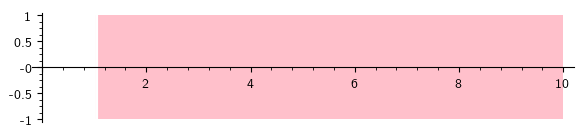

In [31]:
with suppress_warnings():
    simple_sig_ctx.plot().show()

In [32]:
prop_ctx = G(RIF(0.5, 1.2), (~Q | ({x: RIF(0.3,0.4)} >> F(RIF(4, 5), P))))

finally, we can put this together to verify complex temporal/contextual properties:

$$\mathop{\mathbf{G}_{[0.5, 1.1]}} (x > 1.1 \implies [0.3,0.4] \, x \triangleright \mathop{\mathbf{F}_{[4, 5]}} ((x - 1)^2 + y^2 > 0.2))$$

In [33]:
sig_ctx = prop_ctx.signal_for_system(vf, v2, 10, **kwargs_ctx)

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
Computed 148 flowpipes in 1.6090962886810303 sec
In G.signal
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
compos

in loop
[0.0..11.201000000000002] overlaps [1.2005978056155513..1.2210402985046849]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..11.201000000000002] overlaps [1.2210402985046849..1.243527040682732]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..11.201000000000002] overlaps [1.243527040682732..1.2682624570785834]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..11.201000000000002] overlaps [1.2682624570785834..1.2954714151140203]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..11.201000000000002] overlaps [1.2954714151140203..1.3254012689530008]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..11.201000000000002] overlaps [1.3254012689530008..1.3583241081758792]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..11.201000000000002] overlaps [1.3583241081758792..1.3945392313210456]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..11.201000000000002] overlaps [1.3945392313210456..1.4343758667807287]
d

fp_compo->has_value() = True
in loop
[0.0..5.600500000000001] overlaps [2.3917046091295044..2.4727749004479915]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..5.600500000000001] overlaps [2.4727749004479915..2.5619522208983274]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..5.600500000000001] overlaps [2.5619522208983274..2.6600472733936966]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..5.600500000000001] overlaps [2.6600472733936966..2.71399955226615]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..5.600500000000001] overlaps [2.71399955226615..2.7733470590258484]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..5.600500000000001] overlaps [2.7733470590258484..2.8386293164615166]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..5.600500000000001] overlaps [2.8386293164615166..2.9104397996407516]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..5.600500000000001] overlaps [2.9104397996407516..2.

fp_compo->has_value() = True
in loop
[0.0..1.4001250000000003] overlaps [0.9132470422373311..0.9393014751385421]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..1.4001250000000003] overlaps [0.9393014751385421..0.9679613513298743]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..1.4001250000000003] overlaps [0.9679613513298743..0.983724283235107]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..1.4001250000000003] overlaps [0.983724283235107..1.001063508330863]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..1.4001250000000003] overlaps [1.001063508330863..1.0201366559361946]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..1.4001250000000003] overlaps [1.0201366559361946..1.0411171183020593]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..1.4001250000000003] overlaps [1.0411171183020593..1.0641956269045105]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..1.4001250000000003] overlaps [1.064195626904

fp_compo->has_value() = True
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in 

fp_compo->has_value() = True
in loop
[0.35003125000000007..0.7000625000000001] overlaps [0.38537556481385055..0.4092658345202626]
doing normal eval
fp_compo->has_value() = True
in loop
[0.35003125000000007..0.7000625000000001] overlaps [0.4092658345202626..0.42240548285878926]
doing normal eval
fp_compo->has_value() = True
in loop
[0.35003125000000007..0.7000625000000001] overlaps [0.42240548285878926..0.43685909603116857]
doing normal eval
fp_compo->has_value() = True
in loop
[0.35003125000000007..0.7000625000000001] overlaps [0.43685909603116857..0.4527580705207858]
doing normal eval
fp_compo->has_value() = True
in loop
[0.35003125000000007..0.7000625000000001] overlaps [0.4527580705207858..0.47024694245936477]
doing normal eval
fp_compo->has_value() = True
in loop
[0.35003125000000007..0.7000625000000001] overlaps [0.47024694245936477..0.48948470159180163]
doing normal eval
fp_compo->has_value() = True
in loop
[0.35003125000000007..0.7000625000000001] overlaps [0.48948470159180163..

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
in eval
fp.size = 148
fp_compo.size = 148
flowpipesCompo.size = 0
domains.size = 148
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
[0.5250468750000001..0.6125546875000001] overlaps [0.5222850809126065..0.5350878096152433]
doing normal eval
fp_compo->has_value() = True
in loop
[0.5250468750000001..0.6125546875000001] overlaps [0.5350878096152433..0.5491708111881437]
doing normal eval
fp_compo->has_value() = Tru

fp_compo.size = 148
flowpipesCompo.size = 0
domains.size = 148
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
[0.7000625000000001..0.8750781250000002] overlaps [0.685037180839534..0.701640671360119]
doing normal eval
fp_compo->has_value() = True
in loop
[0.7000625000000001..0.8750781250000002] overlaps [0.701640671360119..0.7199045109327624]
doing normal eval
fp_compo->has_value() = True
in loop
[0.7000625000000001..0.8750781250000002] overlaps [0.7199045109327624..0.7399947344626703]
doing normal eval
fp_compo->has_value() = True
in loop
[0.7000625000000001..0.8750781250000002] overlaps [0.7399947344626703..0.7620939803455689]
doing normal eval
fp_compo->has_value() = True
in loop
[0.7000625000000001..0.8750781250000002] overlaps [0

var = y type(var) = <class 'str'> var_str = y
in eval
fp.size = 148
fp_compo.size = 148
flowpipesCompo.size = 0
domains.size = 148
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
[0.9625859375000002..1.0500937500000003] overlaps [0.9393014751385421..0.9679613513298743]
doing normal eval
fp_compo->has_value() = True
in loop
[0.9625859375000002..1.0500937500000003] overlaps [0.9679613513298743..0.983724283235107]
doing normal eval
fp_compo->has_value() = True
in loop
[0.9625859375000002..1.0500937500000003] overlaps [0.983724283235107..1.001063508330863]
doing normal eval
fp_compo->has_value() = True
in loop
[0.9625859375000002..1.050

composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
o

orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5

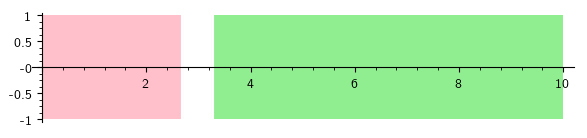

In [34]:
sig_ctx.plot()

However, monitoring alternating temporal and contextual operators can be very expensive!

On (small) example system takes ~13 sec; grows exponentially with level of nesting

## Monitoring under masks

A major limitation of signals is that they must be calculated for an unbroken interval of time.

e.g. if we want to know if $\mathop{\mathbf F_{[9, 10]}} \varphi$ is true at time zero, the signal for $\varphi$ must be computed for $10$ seconds even though it only refers to the behaviour of the system for the last one second.

Masking restricts signal monitoring to a specific subregion of time described by a boolean signal.

e.g. for atomic proposition $\varphi \triangleq (x - 1)^2 + y^2 > 0.2$

In [35]:
mask = Mask(RIF(0, 10),
            [RIF(0.5, 4), RIF(7, 8)])
res = graphics_array(
    [
        sigP.plot(aspect_ratio=p_ratio)
            + text(r'$\varphi$', (10.8, 1), fontsize="xx-large"),
        mask.plot(aspect_ratio=p_ratio)
            + text(r'$m$', (10.8, 1), fontsize="xx-large"),
        P.signal_for_system(*sys_args, mask=mask, **sys_kwargs).plot(aspect_ratio=p_ratio)
            + text(r'$\varphi|_m$', (10.8, 1), fontsize="xx-large"),
    ],
    3, 1
)

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
Computed 501 flowpipes in 3.8111112117767334 sec
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
order

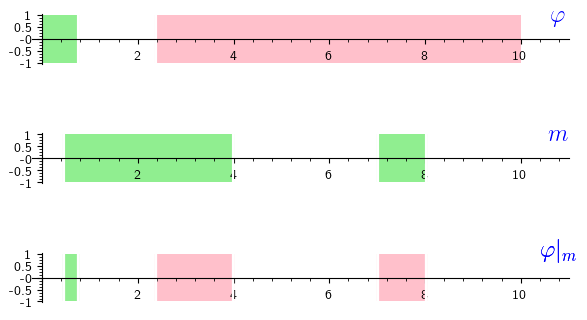

In [36]:
with suppress_warnings():
    res.show()

<p class="list-heading"><strong>Method:</strong></p>

 - Monitor only Taylor-model segments which intersect with the mask
 - On these, restrict the Taylor-model time-domain

### Basic temporal operators

For temporal operators we timeshift forwards instead of backwards.

Suppose we want to monitor $\mathop{\mathbf F_{[a, b]} \varphi}$ under mask $m = (I_j)_j$. We can do this knowing $s_{\varphi}(t)$ at any timepoint $t$ such that $m(t')$ is true at some point between $a$ and $b$ seconds ago. Therefore it suffices to monitor $\varphi$ under the mask,
$$
    \mathop{{\mathbf P}_{[a, b]}} m = (I_j \oplus [a, b])_j
$$

In fact, the same mask works for $\mathop{\mathbf G_{[a, b]} \varphi}$ also.

If we just want to know if the formula is true/false at time $0$, we start with the mask $([0])$ and, for temporal subformulae, this is translated forwards to the relevant regions of time.



In [37]:
label_pos = (14.8, 1)
duration = 15.5
p_range = RIF(0, duration)
sigPl = P.signal_for_system(*(sys_args[:-1] + (14,)), **sys_kwargs)
res = graphics_array(
    [
        sigPl.to_domain(p_range).plot(aspect_ratio=p_ratio)
            + text(r'$\varphi$', label_pos, fontsize="xx-large"),
        mask.to_domain(p_range).plot(aspect_ratio=p_ratio)
            + text(r'$m$', label_pos, fontsize="xx-large"),
        mask.P(RIF(2, 5)).to_domain(p_range).plot(aspect_ratio=p_ratio)
            + text(r'$\mathop{\mathbf P_{[2, 5]}} m$', label_pos, fontsize="xx-large"),
        P.signal_for_system(*(sys_args[:-1] + (duration,)),
                            mask=mask.P(RIF(2, 5)),
                            **sys_kwargs).to_domain(p_range).plot(aspect_ratio=p_ratio)
            + text(r'$\varphi|_{\mathop{\mathbf P_{[2, 5]}} m}$', label_pos, fontsize="xx-large"),
#         P.signal_for_system(*(sys_args[:-1] + (duration,)),
#                             mask=mask.P(RIF(2, 5)),
#                             **sys_kwargs).F(RIF(2, 5)).to_domain(p_range).plot(aspect_ratio=p_ratio)
#             + text(r'$\mathop{\mathbf F_{[2, 5]}} \varphi|_m$', label_pos, fontsize="xx-large"),
        F(RIF(2, 5), P
          ).signal_for_system(*sys_args, mask=mask,
                              **sys_kwargs).with_mask(mask).to_domain(p_range).plot(aspect_ratio=p_ratio)
            + text(r'$\mathop{\mathbf F_{[2, 5]}} \varphi|_m$', label_pos, fontsize="xx-large"),
    ],
    5, 1
)

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
Computed 701 flowpipes in 4.41361403465271 sec
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders 

composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
o

E.g.

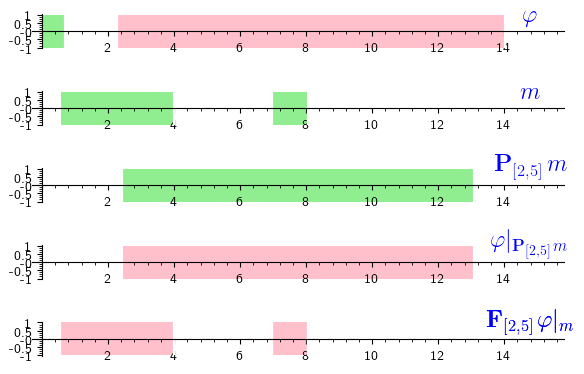

In [38]:
with suppress_warnings():
    res.show()

### Logical operations

In propositional logic $\varphi \vee \psi$ shortcircuiting allows us to avoid evaulating $\psi$ whenever $\varphi$ is true.

We extend this optimization to temporal logic by defining the *or-mask* of $\varphi$ by

$$
    m_\varphi^{\mathrm{or}}(t) = \begin{cases}
        \mathbf T & \text{if $s_\varphi(t) = \mathbf F$ or $s_\varphi(t) = \mathbf U$} \\
        \mathbf F & \text{if $s_\varphi(t) = \mathbf T$}
    \end{cases}
$$

Then we can compute the signal for $\varphi \vee \psi$ under mask $m$ by

$$
    s_{\varphi \vee \psi}|_m
    =
    s_\varphi|_m \vee s_\psi|_{m \wedge m^{\mathrm{or}}_\varphi}
$$

In [39]:
label_pos = (11.2, 1)
res = graphics_array(
    [
        sigP.plot(aspect_ratio=p_ratio) + text(r'$\varphi$', label_pos, fontsize="xx-large"),
        sigQ.plot(aspect_ratio=p_ratio) + text(r"$\psi$", label_pos, fontsize="xx-large"),
        sigP.to_mask_or().plot(aspect_ratio=p_ratio) + text(r'$m_\varphi^{\mathrm{or}}$', label_pos, fontsize="xx-large"),
        (sigP | sigQ.with_mask(sigP.to_mask_or())).to_domain(RIF(0, 10)).plot(aspect_ratio=p_ratio)
            + text(r"$\varphi \vee \psi|_{m_\varphi^{\mathrm{or}}}$", label_pos, fontsize="xx-large"),
    ],
    4, 1
)

E.g. computing $\varphi \vee \psi$

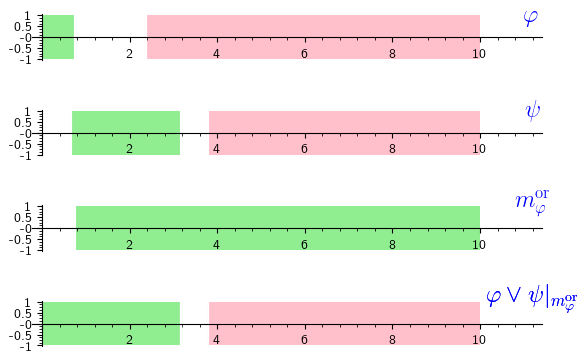

In [40]:
with suppress_warnings():
    res.show()

The case for $\varphi \wedge \psi$ is dual.

**Audience question**: what mask should we use to monitor $\neg\varphi$ under $m$?

### Masking context operator

Masking also applies to context operators $\mathcal C \triangleright \varphi$ by restricting regions of the time domain for which we apply context jump $\mathcal C$.

Thus masking context operators not only saves monitoring cost, but reduces the number of flow* validated integrations.

e.g. we can now monitor the following property in ~$7$ sec (a ~$2\times$ speedup)

$$\mathop{\mathbf{G}_{[0.5, 1.1]}} (x > 1.1 \implies [0.3,0.4] \, x \triangleright \mathop{\mathbf{F}_{[4, 5]}} ((x - 1)^2 + y^2 > 0.2))$$

In [41]:
sig_ctx = prop_ctx.signal_for_system(vf, v2, 10, **kwargs_ctx, use_masks=True)

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
Computed 148 flowpipes in 1.5659000873565674 sec
In G.signal
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
compos

in loop
[0.5..1.3284445286724709] overlaps [0.6210659425179577..0.6437467573811295]
doing normal eval
fp_compo->has_value() = True
in loop
[0.5..1.3284445286724709] overlaps [0.6437467573811295..0.656221205555874]
doing normal eval
fp_compo->has_value() = True
in loop
[0.5..1.3284445286724709] overlaps [0.656221205555874..0.6699430985480931]
doing normal eval
fp_compo->has_value() = True
in loop
[0.5..1.3284445286724709] overlaps [0.6699430985480931..0.685037180839534]
doing normal eval
fp_compo->has_value() = True
in loop
[0.5..1.3284445286724709] overlaps [0.685037180839534..0.701640671360119]
doing normal eval
fp_compo->has_value() = True
in loop
[0.5..1.3284445286724709] overlaps [0.701640671360119..0.7199045109327624]
doing normal eval
fp_compo->has_value() = True
in loop
[0.5..1.3284445286724709] overlaps [0.7199045109327624..0.7399947344626703]
doing normal eval
fp_compo->has_value() = True
in loop
[0.5..1.3284445286724709] overlaps [0.7399947344626703..0.7620939803455689]
doing

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
in eval
fp.size = 148
fp_compo.size = 148
flowpipesCompo.size = 0
domains.size = 148
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
[0.5..0.6035555660840588] overlaps [0.48948470159180163..0.5106462366374822]
doing normal eval
fp_compo->has_value() = True
in loop
[0.5..0.6035555660840588] over

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
in eval
fp.size = 148
fp_compo.size = 148
flowpipesCompo.size = 0
domains.size = 148
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in

in loop
[0.9142222643362354..1.3284445286724709] overlaps [1.1820137211708843..1.2005978056155513]
doing normal eval
fp_compo->has_value() = True
in loop
[0.9142222643362354..1.3284445286724709] overlaps [1.2005978056155513..1.2210402985046849]
doing normal eval
fp_compo->has_value() = True
in loop
[0.9142222643362354..1.3284445286724709] overlaps [1.2210402985046849..1.243527040682732]
doing normal eval
fp_compo->has_value() = True
in loop
[0.9142222643362354..1.3284445286724709] overlaps [1.243527040682732..1.2682624570785834]
doing normal eval
fp_compo->has_value() = True
in loop
[0.9142222643362354..1.3284445286724709] overlaps [1.2682624570785834..1.2954714151140203]
doing normal eval
fp_compo->has_value() = True
in loop
[0.9142222643362354..1.3284445286724709] overlaps [1.2954714151140203..1.3254012689530008]
doing normal eval
fp_compo->has_value() = True
in loop
[0.9142222643362354..1.3284445286724709] overlaps [1.3254012689530008..1.3583241081758792]
doing normal eval
fp_compo-

in eval
fp.size = 148
fp_compo.size = 148
flowpipesCompo.size = 0
domains.size = 148
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
[0.966000047378265..1.0177778304202945] overlaps [0.9393014751385421..0.9679613513298743]
doing normal eval
fp_compo->has_value() = True
in loop
[0.966000047378265..1.0177778304202945] overlaps [0.9679613513298743..0.983724283235107]
doing normal eval
fp_compo->has_value() = True
in loop
[0.966000047378265..1.0177778304202945] overlaps [0.983724283235107..1.001063508330863]
doing normal eval
fp_compo->has_value() = True
in loop
[0.966000047378265..1.0177778304202945] overlaps [1.001063508330863..1.0201

fp_compo->has_value() = True
in loop
[1.1213333965043533..1.3284445286724709] overlaps [1.2682624570785834..1.2954714151140203]
doing normal eval
fp_compo->has_value() = True
in loop
[1.1213333965043533..1.3284445286724709] overlaps [1.2954714151140203..1.3254012689530008]
doing normal eval
fp_compo->has_value() = True
in loop
[1.1213333965043533..1.3284445286724709] overlaps [1.3254012689530008..1.3583241081758792]
doing normal eval
fp_compo->has_value() = True
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in lo

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
[11.200000000000001..11.200000000000001] overlaps [10.996609400288932..11.200999999999002]
doing normal eval
fp_compo->has_value() = False
composing fp
orders = [5, 5]
run = Tr

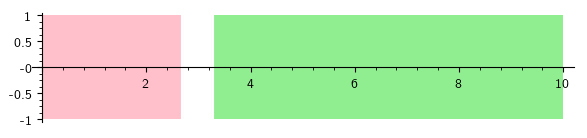

In [42]:
sig_ctx.plot()

Speedup increases with duration, system dimension, and alternation depth

In [43]:
prop_ctx.signal_for_system(vf, v2, 0, **kwargs_ctx)(0)

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
Computed 61 flowpipes in 0.6848163604736328 sec
In G.signal
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composi

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
in eval
fp.size = 61
fp_compo.size = 61
flowpipesCompo.size = 0
domains.size = 61
in loop
[0.0..0.150125] overlaps [0.0..0.03125]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..0.150125] overlaps [0.03125..0.0484375]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..0.150125] overlaps [0.0484375..0.06734375000000001]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..0.150125] overlaps [0.06734375000000001..0.08814062500000003]
doing normal eval
fp_compo->has_value() = True
in loop
[0.0..0.150125] overlaps [0.08814062500000003..0.11101718750000004]
d

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
[0.30025..0.37531250000000005] overlaps [0.2948126464931844..0.3096466243675298]
doing normal eval
fp_compo->has_value() = True
in loop
[0.30025..0.37531250000000005] overlaps [0.3096466243675298..0.32596400002930975]
doing normal eval
fp_compo->has_value() = True
in loop
[0.30025..0.37531250000000005] overlaps [0.32596400002930975..0.3439131132572677]
doing normal eval
fp_compo->has_value() = True
in loop
[0.30025..0.37531250000000005] overlaps [0.3439131132572677..0.36365713780802145]
doing normal eval
fp_compo->has_value() = True
in loop
[0.30025..0.37531250000000005] overlaps [0.36365713780802145..0.38537556481385055]
doing normal eval
fp_compo->has_value() = True
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in 

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
in eval
fp.size = 61
fp_compo.size = 61
flowpipesCompo.size = 0
domains.size = 61
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
[0.6005..0.6755625000000001] overlaps [0.6004470199150741..0.6210659425179577]
doing normal eval
fp_compo->has_value() = True
in loop
[0.6005..0.6755625000000001] overlaps [0.6210659425179577..0.6437467573811295]
doing normal eval
fp_compo->has_value() = True
in loop
[0.6005..0.6755625000000001] overlaps [0.6437467573811295..0.656221205555874]
doing normal eval
fp_compo->has_value() = True
in loop
[0.6005..0.675562500

in loop
[0.9758125..1.050875] overlaps [0.983724283235107..1.001063508330863]
doing normal eval
fp_compo->has_value() = True
in loop
[0.9758125..1.050875] overlaps [1.001063508330863..1.0201366559361946]
doing normal eval
fp_compo->has_value() = True
in loop
[0.9758125..1.050875] overlaps [1.0201366559361946..1.0411171183020593]
doing normal eval
fp_compo->has_value() = True
in loop
[0.9758125..1.050875] overlaps [1.0411171183020593..1.0641956269045105]
doing normal eval
fp_compo->has_value() = True
in loop
in loop
in loop
in loop
in loop
run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
in eval
fp.size = 61
fp_compo.size = 61
flowpipesCompo.size = 0
domains.size = 61
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in l

False

In [44]:
prop_ctx.signal_for_system(vf, v2, 0, use_masks=True, **kwargs_ctx)(0)

run = True
vars = ['x', 'y']
var = x type(var) = <class 'str'> var_str = x
var = y type(var) = <class 'str'> var_str = y
Computed 61 flowpipes in 0.6740810871124268 sec
In G.signal
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composing fp
orders = [5, 5]
composi

in eval
fp.size = 61
fp_compo.size = 61
flowpipesCompo.size = 0
domains.size = 61
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
[0.5875..0.675] overlaps [0.5817025448215436..0.6004470199150741]
doing normal eval
fp_compo->has_value() = True
in loop
[0.5875..0.675] overlaps [0.6004470199150741..0.6210659425179577]
doing normal eval
fp_compo->has_value() = True
in loop
[0.5875..0.675] overlaps [0.6210659425179577..0.6437467573811295]
doing normal eval
fp_compo->has_value() = True
in loop
[0.5875..0.675] overlaps [0.6437467573811295..0.656221205555874]
doing normal eval
fp_compo->has_value() = True
in loop
[0.5875..0.675] overlaps [0.656221205555874..0.6699430985480931]
doing normal eval
fp_compo->has_value() = True
in loop
[0.5875..0.675] overlaps [0.6699430985480931..0.68503718083

in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
in loop
[0.85..1.025] overlaps [0.8484535239029896..0.8680286049707665]
doing normal eval
fp_compo->has_value() = True
in loop
[0.85..1.025] overlaps [0.8680286049707665..0.8895611941453211]
doing normal eval
fp_compo->has_value() = True
in loop
[0.85..1.025] overlaps [0.8895611941453211..0.9132470422373311]
doing normal eval
fp_compo->has_value() = True
in loop
[0.85..1.025] overlaps [0.9132470422373311..0.9393014751385421]
doing normal eval
fp_compo->has_value() = True
in loop
[0.85..1.025] overlaps [0.9393014751385421..0.9679613513298743]
doing normal eval
fp_compo->has_value() = True
in loop
[0.85..1.025] overlaps [0.9679613513298743..0.983724283235107]
doing normal e

False

## Questions?

## Appendix: monitoring U

The until operator $\varphi \mathop{\mathbf U_{[a, b]}} \psi$ is more tricky.

The two-valued case used a decomposition into boolean signals

$$
    s_{\varphi \mathop{\mathbf U_{[a, b]}} \psi}
    =
    \bigvee_j s_\varphi^j \mathop{\mathbf{U}_{[a, b]}}s_{\psi} 
    =
    \bigvee_j s_\varphi^j \mathop{\mathbf{F}_{[a, b]}} \left(s_\varphi^j \wedge s_{\psi}\right) 
$$

and $s_\varphi = \bigvee_j s_\varphi^j$ where $s_j$ is a *unitary signal* e.g.

$s_\varphi = s_{\varphi}^1 \vee s_{\varphi}^2$ where we have signals

In [45]:
sig  = Signal(RIF(0, 10),
              [(RIF(0, 2), False), (RIF(2, 3), True), (RIF(3, 4), False), (RIF(4, 6), True), (RIF(6, 10), False)])
sig1 = Signal(RIF(0, 10),
              [(RIF(0, 2), False), (RIF(2, 3), True), (RIF(3, 10), False)])
sig2 = Signal(RIF(0, 10),
              [(RIF(0, 4), False), (RIF(4, 6), True), (RIF(6, 10), False)])

res = graphics_array([sig.plot(aspect_ratio=p_ratio)  + text(r"$s_\varphi$",   (10.8, 1), fontsize="xx-large"),
                      sig1.plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^1$", (10.8, 1), fontsize="xx-large"),
                      sig2.plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^2$", (10.8, 1), fontsize="xx-large")],
                     3, 1)

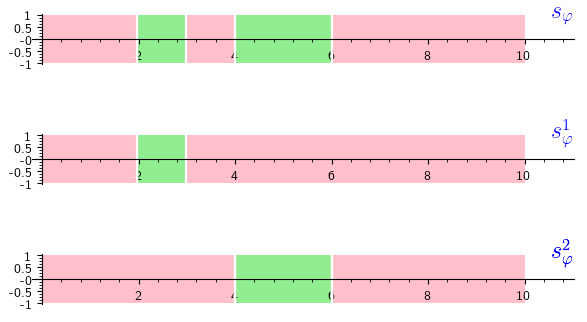

In [46]:
res

For three-valued signals we extend this into a decomposition into three-valued step-signals e.g. $s_\varphi = \bigvee_j s_\varphi^j$ 

In [47]:
sig  = Signal(RIF(0, 10),
              [(RIF(0, 1), False), (RIF(2, 3), True), (RIF(4, 5), True),
               (RIF(6, 7), False), (RIF(7.5, 8), True), (RIF(8.5, 9), False)])
# sig1 = Signal(RIF(0, 10),
#               [(RIF(0, 1), False), (RIF(2, 3), True), (RIF(6, 10), False)])
# sig2 = Signal(RIF(0, 10),
#               [(RIF(0, 1), False), (RIF(4, 5), True), (RIF(6, 10), False)])
# sig3 = Signal(RIF(0, 10),
#               [(RIF(0, 7), False), (RIF(8, 9), True)])
sig1, sig2, sig3, sig4 = list(sig.decomposition)

res = graphics_array([sig.plot(aspect_ratio=p_ratio)  + text(r"$s_\varphi$",   (10.8, 1), fontsize="xx-large"),
                      sig1.plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^1$", (10.8, 1), fontsize="xx-large"),
                      sig2.plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^2$", (10.8, 1), fontsize="xx-large"),
                      sig3.plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^3$", (10.8, 1), fontsize="xx-large"),
                      sig4.plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^4$", (10.8, 1), fontsize="xx-large"),
                     ], 5, 1)

domain   = [0.0000000000000000 .. 10.000000000000000]
values   = [('[0.0000000000000000 .. 1.0000000000000000]', False), ('[2.0000000000000000 .. 3.0000000000000000]', True), ('[4.0000000000000000 .. 5.0000000000000000]', True), ('[6.0000000000000000 .. 7.0000000000000000]', False), ('[7.5000000000000000 .. 8.0000000000000000]', True), ('[8.5000000000000000 .. 9.0000000000000000]', False)]
falses1  = [('[0.0000000000000000 .. 1.0000000000000000]', False)]
trues    = [('[2.0000000000000000 .. 3.0000000000000000]', True), ('[4.0000000000000000 .. 5.0000000000000000]', True)]
falses2  = [('[6.0000000000000000 .. 7.0000000000000000]', False)]
u_domain = [1.0000000000000000 .. 6.0000000000000000]
domain   = [7.0000000000000000 .. 10.000000000000000]
values   = [('[7.0000000000000000 .. 7.0000000000000000]', False), ('[7.5000000000000000 .. 8.0000000000000000]', True), ('[8.5000000000000000 .. 9.0000000000000000]', False)]
falses1  = [('[7.0000000000000000 .. 7.0000000000000000]', False)]
tr

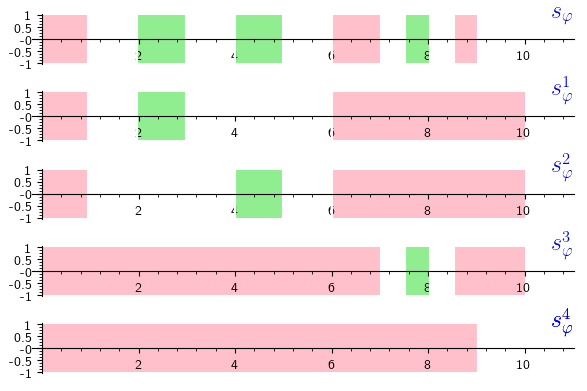

In [48]:
with suppress_warnings():
    res.show()

In [49]:
res.save("/home/twright/Drive/Documents/PhD/Flowstar Signals/images/decomposition.pdf")

/usr/lib64/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


$$
\text{We can then compute }
s_{\varphi \mathop{\mathbf U_{[a, b]}} \psi}
=
\bigvee_j s_\varphi^j \wedge \mathop{\mathbf{F}_{[a, b]}} \left(s_\varphi^j \wedge s_{\psi}\right)
\text{ e.g.}
$$

In [50]:
sigQ

Signal([0.0000000000000000 .. 10.000000000000000], [([0.64000000000000056 .. 3.2064719457580462], True), ([3.8200000000000033 .. 10.000000000000000], False)], mask=None)

In [51]:
sigR = Signal(RIF(0, 10), [(RIF(0.65, 3.20), True), (RIF(3.83, 5), False), (RIF(6, 10), True)])

In [52]:
label_pos = (10.8, 1)
label_pos2 = (11.8, 1)
res = graphics_array(
    [sig.plot(aspect_ratio=p_ratio)  + text(r"$s_\varphi$",   label_pos, fontsize="xx-large"),
     sigR.plot(aspect_ratio=p_ratio)  + text(r"$s_\psi$",     label_pos, fontsize="xx-large"),
     (sig1 & sigR).plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^1$", label_pos, fontsize="xx-large"),
     (sig2 & sigR).plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^2$", label_pos, fontsize="xx-large"),
     (sig3 & sigR).plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^3$", label_pos, fontsize="xx-large"),
     (sig4 & sigR).plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^4$", label_pos, fontsize="xx-large"),
    ], 6, 1)


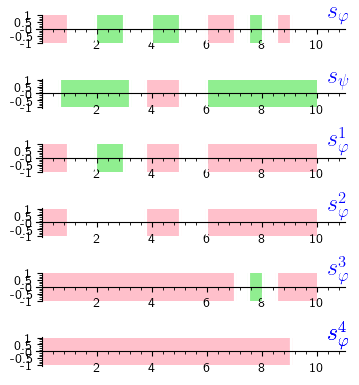

In [53]:
with suppress_warnings():
    res.show()

In [54]:
label_pos = (8.3, 0)
label_pos2 = (9.3, 0)
text_kwargs = dict(fontsize="xx-large", horizontal_alignment="left", axes=False, background_color="white",
                   zorder=11)
# rect = polygon([(9.8, -1), (9.8, 1), (16, 1), (16, -1)],
#                color="white", zorder=10)
term1, term2, term3, term4 = [(s & sigR).F(RIF(0.5, 2)) for s in [sig1, sig2, sig3, sig4]]
figs2 = [
    term1.plot(aspect_ratio=p_ratio)
         + text(r"$\mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^1 \wedge \psi\right)$",
                label_pos2, **text_kwargs),
     term2.plot(aspect_ratio=p_ratio)
         + text(r"$\mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^2 \wedge \psi\right)$",
                label_pos2, **text_kwargs),
     term3.plot(aspect_ratio=p_ratio)
         + text(r"$\mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^3 \wedge \psi\right)$",
                label_pos2, **text_kwargs),
     term4.plot(aspect_ratio=p_ratio)
         + text(r"$\mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^3 \wedge \psi\right)$",
                label_pos2, **text_kwargs),
]
res = graphics_array(figs2, ncols=1)

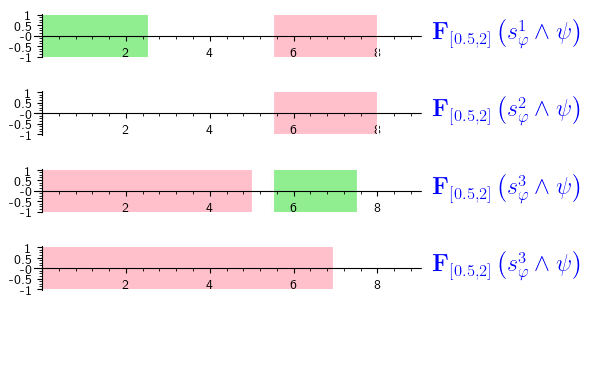

In [55]:
with suppress_warnings():
    res.show()

In [56]:
sigR

Signal([0.0000000000000000 .. 10.000000000000000], [([0.65000000000000002 .. 3.2000000000000002], True), ([3.8300000000000000 .. 5.0000000000000000], False), ([6.0000000000000000 .. 10.000000000000000], True)], mask=None)

In [57]:
(sig1 & term1) | (sig2 & term2) | (sig3 & term3) | (sig4 & term4)

Signal([0.0000000000000000 .. 9.5000000000000000], [([0.0000000000000000 .. 1.0000000000000000], False), ([2.0000000000000000 .. 2.5000000000000000], True), ([5.5000000000000000 .. 7.0000000000000000], False), ([7.5000000000000000 .. 7.5000000000000000], True), ([8.0000000000000000 .. 8.0000000000000000], False), ([8.5000000000000000 .. 9.0000000000000000], False)], mask=None)

/usr/lib64/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


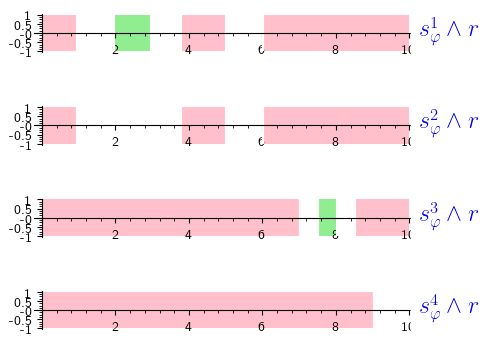

/usr/lib64/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


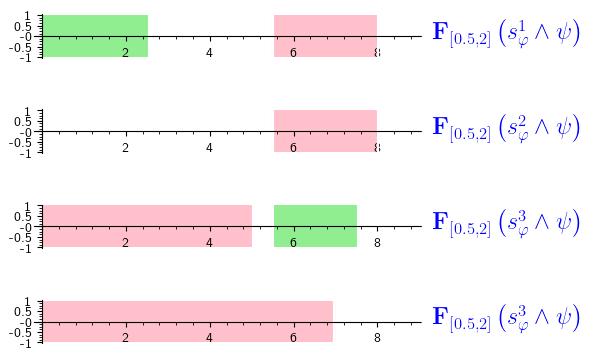

/usr/lib64/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


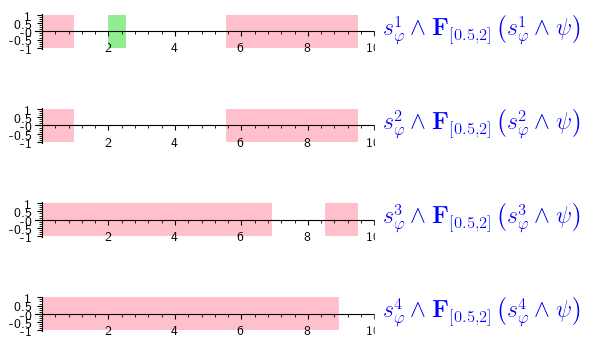

In [58]:
label_pos2 = (10.3, 0)
figs1 = [
     (sig1 & sigR).plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^1 \wedge r$", label_pos2, **text_kwargs),
     (sig2 & sigR).plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^2 \wedge r$", label_pos2, **text_kwargs),
     (sig3 & sigR).plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^3 \wedge r$", label_pos2, **text_kwargs),
     (sig4 & sigR).plot(aspect_ratio=p_ratio) + text(r"$s_\varphi^4 \wedge r$", label_pos2, **text_kwargs),
]
figs3 = [
     (sig1 & term1).plot(aspect_ratio=p_ratio)
         + text(r"$s_\varphi^1 \wedge \mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^1 \wedge \psi\right)$",
                label_pos2, **text_kwargs),
     (sig2 & term2).plot(aspect_ratio=p_ratio)
         + text(r"$s_\varphi^2 \wedge \mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^2 \wedge \psi\right)$",
                label_pos2, **text_kwargs),
     (sig3 & term3).plot(aspect_ratio=p_ratio)
         + text(r"$s_\varphi^3 \wedge \mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^3 \wedge \psi\right)$",
                label_pos2, **text_kwargs),
     (sig4 & term4).plot(aspect_ratio=p_ratio)
         + text(r"$s_\varphi^4 \wedge \mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^4 \wedge \psi\right)$",
                label_pos2, **text_kwargs),
]
gs = [
    graphics_array(col, ncols=1, nrows=4)
        for col in zip(*zip(figs1, figs2, figs3))
]
for i, (g, fs) in enumerate(zip(gs, [[5,4], [6, 4], [6, 4]]), 1):
    g.show(figsize=fs)
    g.save("fig{}.pdf".format(i), figsize=fs)
# res.show(figsize=[12, 3])

/usr/lib64/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


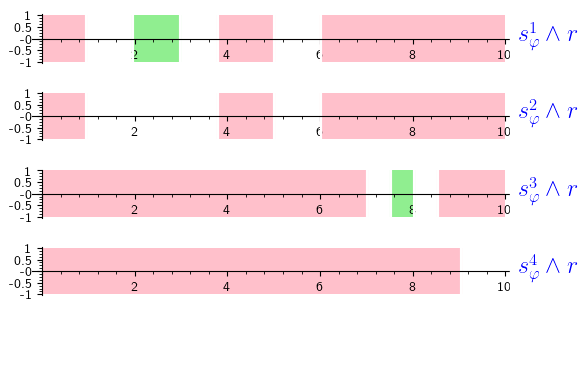

/usr/lib64/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


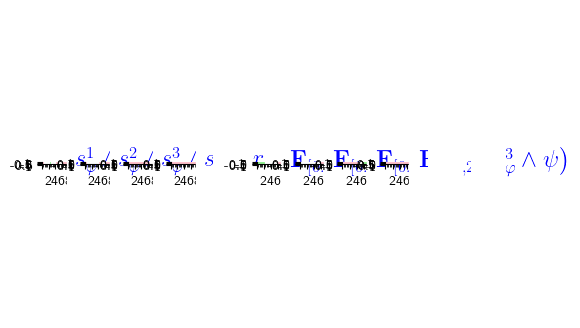

In [59]:
g1 = graphics_array(list(zip(*zip(figs1, figs2, figs3)))[0], ncols=1)
g1.show()
g2 = graphics_array(list(zip(*zip(figs1, figs2, figs3)))[1], ncols=1)
graphics_array(
    [g1.plot(), g2.plot()],
    nrows=1)

/usr/lib64/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


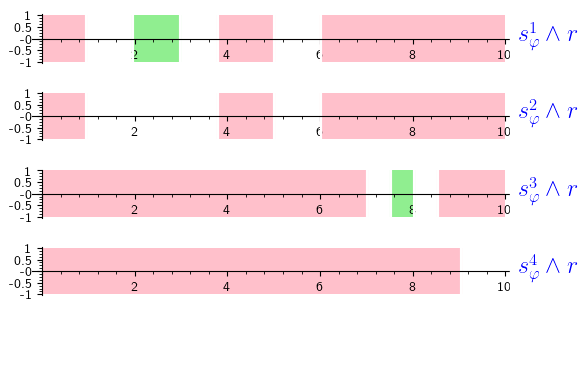

In [60]:
g1.plot()

In [61]:
label_pos = (10, 0)
text_kwargs = dict(fontsize="xx-large", horizontal_alignment="left", axes=False, background_color="white",
                   zorder=11)
rect = polygon([(9.8, -1), (9.8, 1), (16, 1), (16, -1)],
               color="white", zorder=10)
terms = [s & (s & sigQ).F(RIF(0.5, 2)) for s in [sig1, sig2, sig3]]
figs = [
    terms[0].plot(aspect_ratio=p_ratio)
         + text(r"$s_\varphi^1 \wedge \mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^1 \wedge \psi\right)$",
                label_pos, **text_kwargs)
         + rect,
     terms[1].plot(aspect_ratio=p_ratio)
         + text(r"$s_\varphi^2 \wedge \mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^2 \wedge \psi\right)$",
                label_pos, **text_kwargs)
         + rect,
     terms[2].plot(aspect_ratio=p_ratio)
         + text(r"$s_\varphi^3 \wedge \mathop{\mathbf F_{[0.5, 2]}} \left(s_\varphi^3 \wedge \psi\right)$",
                label_pos, **text_kwargs)
         + rect,
     (terms[0] | terms[1] | terms[2]).plot(aspect_ratio=p_ratio)
         + text(r"$s_{\varphi \mathop{\mathbf U_{[0.5, 2]}} \psi}$",
                label_pos, **text_kwargs)
         + rect
]
res = graphics_array(figs, 4, 1)

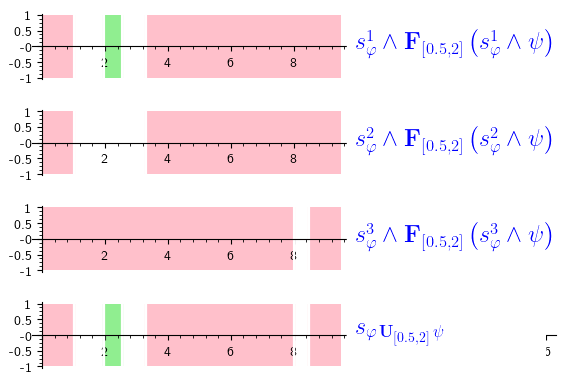

In [62]:
with suppress_warnings():
    res.show()

In [63]:
(~sigR).decomposition

domain   = [0.0000000000000000 .. 10.000000000000000]
values   = [('[0.65000000000000002 .. 3.2000000000000002]', False), ('[3.8300000000000000 .. 5.0000000000000000]', True), ('[6.0000000000000000 .. 10.000000000000000]', False)]
falses1  = []
trues    = []
falses2  = [('[0.65000000000000002 .. 3.2000000000000002]', False)]
u_domain = [0.0000000000000000 .. 0.65000000000000003]
domain   = [3.2000000000000001 .. 10.000000000000000]
values   = [('[3.2000000000000001 .. 3.2000000000000002]', False), ('[3.8300000000000000 .. 5.0000000000000000]', True), ('[6.0000000000000000 .. 10.000000000000000]', False)]
falses1  = [('[3.2000000000000001 .. 3.2000000000000002]', False)]
trues    = [('[3.8300000000000000 .. 5.0000000000000000]', True)]
falses2  = [('[6.0000000000000000 .. 10.000000000000000]', False)]
u_domain = [3.2000000000000001 .. 6.0000000000000000]
domain   = [10.000000000000000 .. 10.000000000000000]
values   = [('[10.000000000000000 .. 10.000000000000000]', False)]
falses1  = [(

[Signal([0.0000000000000000 .. 10.000000000000000], [([0.65000000000000002 .. 10.000000000000000], False)], mask=None),
 Signal([0.0000000000000000 .. 10.000000000000000], [([0.0000000000000000 .. 3.2000000000000002], False), ([3.8300000000000000 .. 5.0000000000000000], True), ([6.0000000000000000 .. 10.000000000000000], False)], mask=None),
 Signal([0.0000000000000000 .. 10.000000000000000], [([0.0000000000000000 .. 10.000000000000000], False)], mask=None)]

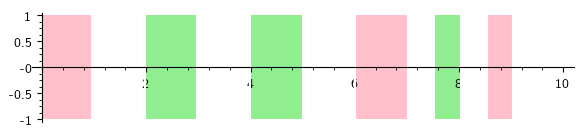

In [69]:
sig.plot()

domain   = [0.0000000000000000 .. 10.000000000000000]
values   = [('[0.0000000000000000 .. 1.0000000000000000]', True), ('[2.0000000000000000 .. 3.0000000000000000]', False), ('[4.0000000000000000 .. 5.0000000000000000]', False), ('[6.0000000000000000 .. 7.0000000000000000]', True), ('[7.5000000000000000 .. 8.0000000000000000]', False), ('[8.5000000000000000 .. 9.0000000000000000]', True)]
falses1  = []
trues    = [('[0.0000000000000000 .. 1.0000000000000000]', True)]
falses2  = [('[2.0000000000000000 .. 3.0000000000000000]', False), ('[4.0000000000000000 .. 5.0000000000000000]', False)]
u_domain = [0.0000000000000000 .. 2.0000000000000000]
domain   = [3.0000000000000000 .. 10.000000000000000]
values   = [('[3.0000000000000000 .. 3.0000000000000000]', False), ('[4.0000000000000000 .. 5.0000000000000000]', False), ('[6.0000000000000000 .. 7.0000000000000000]', True), ('[7.5000000000000000 .. 8.0000000000000000]', False), ('[8.5000000000000000 .. 9.0000000000000000]', True)]
falses1  = [

/usr/lib64/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


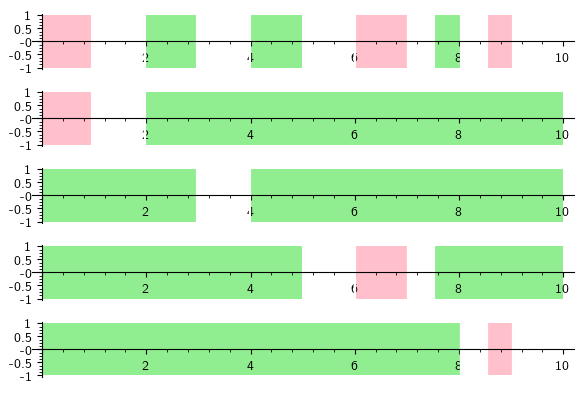

In [85]:
res = graphics_array([sig.plot(aspect_ratio=p_ratio)] + [(~s).plot(aspect_ratio=p_ratio) for s in (~sig).decomposition], 5, 1)
res.save("dual-decomposition.pdf")
res

domain   = [0.0000000000000000 .. 10.000000000000000]
values   = [('[0.0000000000000000 .. 1.0000000000000000]', True), ('[2.0000000000000000 .. 3.0000000000000000]', False), ('[4.0000000000000000 .. 5.0000000000000000]', False), ('[6.0000000000000000 .. 7.0000000000000000]', True), ('[7.5000000000000000 .. 8.0000000000000000]', False), ('[8.5000000000000000 .. 9.0000000000000000]', True)]
falses1  = []
trues    = [('[0.0000000000000000 .. 1.0000000000000000]', True)]
falses2  = [('[2.0000000000000000 .. 3.0000000000000000]', False), ('[4.0000000000000000 .. 5.0000000000000000]', False)]
u_domain = [0.0000000000000000 .. 2.0000000000000000]
domain   = [3.0000000000000000 .. 10.000000000000000]
values   = [('[3.0000000000000000 .. 3.0000000000000000]', False), ('[4.0000000000000000 .. 5.0000000000000000]', False), ('[6.0000000000000000 .. 7.0000000000000000]', True), ('[7.5000000000000000 .. 8.0000000000000000]', False), ('[8.5000000000000000 .. 9.0000000000000000]', True)]
falses1  = [

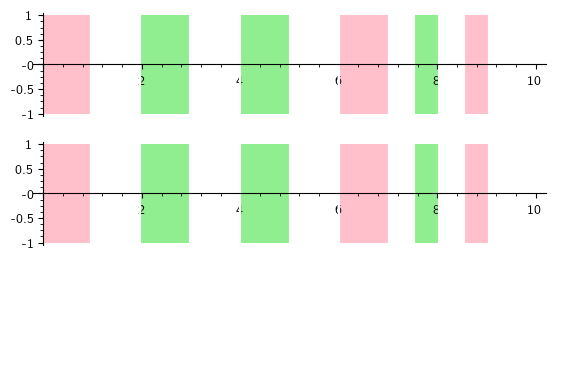

In [84]:
graphics_array([sig.plot(),
                reduce(lambda x, y: x & y, ((~s) for s in (~sig).decomposition)).plot()],
               ncols=1)

/usr/lib64/python3.7/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


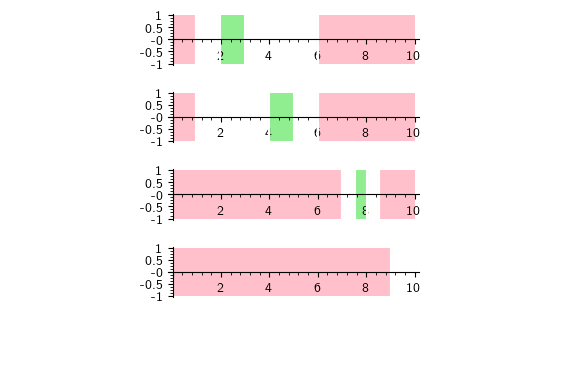

In [71]:
graphics_array([(s).plot() for s in (sig).decomposition], ncols=1)

### Masking Until

How do we monitor $\varphi \mathop{\mathbf U_{[a, b]}} \psi$ under mask $m$? 

**One approach**: use the equation,

$$
    s_{\varphi \mathop{\mathbf U_{[a, b]}} \psi}
    =
    \bigvee_j s_\varphi^j \wedge \mathop{\mathbf{F}_{[a, b]}} \left(s_\varphi^j \wedge s_{\psi}\right) 
$$

and apply masking methods for both logical and temporal operators to find a suitable mask for $\psi$.

**A simpler way**: in fact, it surfices to monitor $\psi$ under the mask

$$
   \mathop{\mathbf H_{[0, b]}} \left(m \wedge m_{\varphi}^{\mathrm{or}}\right)
$$

$\mathbf{H}_{[0, a]} \zeta$: the proposition $\zeta$ has *historically* held between $0$ and $a$ seconds ago. 